In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [7]:
# # data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
# # session_lists = agent_data[('anesthesiaLvrOdd', 'dexmedetomidine')]['session_lists']

# data_class, agent = ('anesthesiaLvrOdd', 'ketamine')
# session_lists = agent_data[('anesthesiaLvrOdd', 'ketamine')]['session_lists']

In [8]:
# pct_correct_thresh_options = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# lever_window = 120
# analysis_window = 15

# top_percent = 0.1

# section_high_perf_windows = {}
# section_pct_correct = {}
# section_pct_correct_by_window = {}

# total_its = 0
# for (data_class, agent) in anesthetic_agent_list[1:]:
#     session_lists = agent_data[(data_class, agent)]['session_lists']
#     for monkey in ['SPOCK', 'PEDRI']:
#         for session in session_lists[monkey]['high']:
#             total_its += 1

# iterator = tqdm(total=total_its)

# for (data_class, agent) in anesthetic_agent_list[1:]:
#     session_lists = agent_data[(data_class, agent)]['session_lists']

#     section_high_perf_windows[(data_class, agent)] = {}
#     section_pct_correct[(data_class, agent)] = {}
#     section_pct_correct_by_window[(data_class, agent)] = {}
#     cfg.params.data_class = data_class
#     delase_results = agent_data[(data_class, agent)]['delase_results']

#     area = 'all'

#     for monkey in ['SPOCK', 'PEDRI']:
#         section_high_perf_windows[(data_class, agent)][monkey] = {}
#         section_pct_correct[(data_class, agent)][monkey] = {}
#         section_pct_correct_by_window[(data_class, agent)][monkey] = {}
#         for session in session_lists[monkey]['high']:
#             section_high_perf_windows[(data_class, agent)][monkey][session] = {}
#             section_pct_correct[(data_class, agent)][monkey][session] = {}
#             section_pct_correct_by_window[(data_class, agent)][monkey][session] = {}

#             if 'propofol' in cfg.params.data_class:
#                 session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f'{session}.mat'), 'r')
#             else:
#                 session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f'{session}.mat'), 'r')
            
#             if 'propofol' not in cfg.params.data_class:
#                 infusion_start = session_file['sessionInfo']['infusionStart'][0, -1]
#             else:
#                 infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
                
#             # --------------------------------------------------
#             # GET HIGH PERFORMANCE MASK
#             # --------------------------------------------------
            
            
#             pct_correct, pct_correct_windows = get_pct_correct(cfg, session_file, lever_window=lever_window, stride=analysis_window)
#             high_perf_times = (pct_correct_windows - infusion_start)/60

#             stab_means = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean())
#             stab_sems = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].std()/np.sqrt(len(x[:int(top_percent*len(x))])))
#             time_vals = (delase_results[session][area].window_start - infusion_start)/60

#             section_info, _, _, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')

#             # for section_name, section_times in section_info:
#             #     section_start, section_end = section_times
#             #     section_start = section_start*60 + infusion_start
#             #     section_end = section_end*60 + infusion_start
#             #     section_mask = (pct_correct_windows >= section_start) & (pct_correct_windows <= section_end)
#             #     section_pct_correct_by_window[(data_class, agent)][monkey][session][section_name] = pct_correct[section_mask]
            
            
#             for pct_correct_thresh in pct_correct_thresh_options:
#                 section_high_perf_windows[(data_class, agent)][monkey][session][pct_correct_thresh] = {}
                
#                 high_perf_mask = (pct_correct > pct_correct_thresh)

#                 perf_start_times = np.array([int(np.round(t)) for t in pct_correct_windows + 60])
#                 stab_start_times = np.array([int(np.round(t)) for t in (time_vals*60 + infusion_start).to_numpy()])
#                 time_bool1 = np.array([t in stab_start_times for t in perf_start_times])
#                 time_bool2 = np.array([t in perf_start_times for t in stab_start_times])
#                 stab_means = stab_means[time_bool2]
#                 stab_sems = stab_sems[time_bool2]
#                 time_vals = time_vals[time_bool2]
#                 high_perf_mask = high_perf_mask[time_bool1]
#                 stab_start_times = stab_start_times[time_bool2]
#                 perf_start_times = perf_start_times[time_bool1]
#                 high_perf_times = high_perf_times[time_bool1]

#                 # --------------------------------------------------
#                 # GET SECTION HIGH PERFORMANCE WINDOWS
#                 # --------------------------------------------------

#                 for section_name, section_times in section_info:
#                     section_start, section_end = section_times
#                     section_start = section_start*60 + infusion_start
#                     section_end = section_end*60 + infusion_start
#                     section_mask = (perf_start_times >= section_start) & (perf_start_times <= section_end)
#                     section_high_perf_windows[(data_class, agent)][monkey][session][pct_correct_thresh][section_name] = high_perf_mask[section_mask].sum()/np.sum(section_mask)


#             # --------------------------------------------------
#             # GET SECTION PCT CORRECT
#             # --------------------------------------------------

#             trial_starts = session_file['trialInfo']['trialStart'][:,0]

#             trial_starts = session_file['trialInfo']['trialStart'][:,0]
#             trial_ends = session_file['trialInfo']['trialEnd'][:,0]
#             tasks = convert_h5_string_array(session_file, session_file['trialInfo']['task'])

#             lever_starts = trial_starts[tasks == 'lever']
#             lever_ends = trial_ends[tasks == 'lever']

#             for section_name, section_times in section_info:
#                 section_start, section_end = section_times
#                 section_start = section_start*60 + infusion_start
#                 section_end = section_end*60 + infusion_start
#                 outcomes = session_file['trialInfo']['lvr_correct'][()][(lever_starts >= section_start) & (lever_ends <= section_end)]
#                 if len(outcomes) > 0:
#                     section_pct_correct[(data_class, agent)][monkey][session][section_name] = outcomes.sum()/len(outcomes)

#             iterator.update(1)
# iterator.close()

In [9]:
len(high_perf_times)

NameError: name 'high_perf_times' is not defined

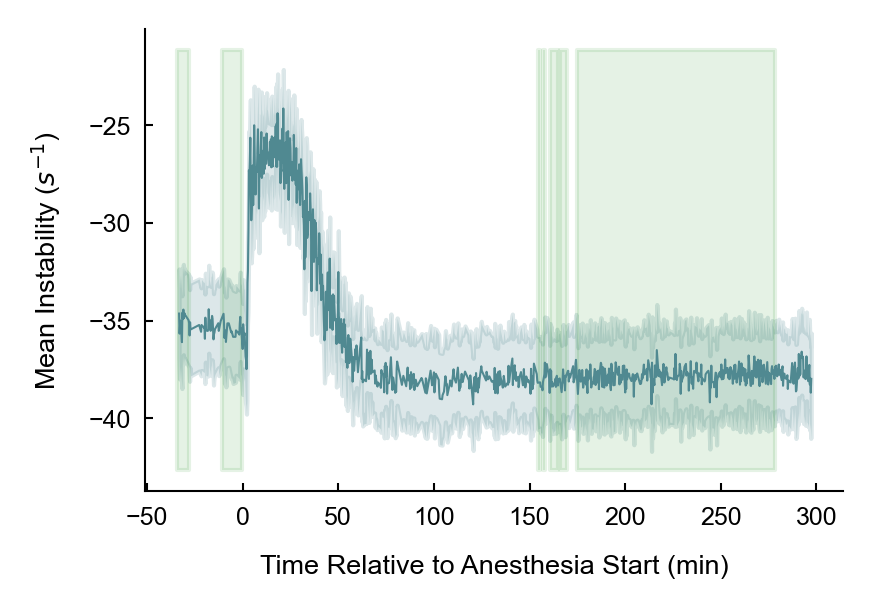

In [100]:
plot_single_session_tracking(session, pct_correct_thresh, time_vals, stab_means, stab_sems, high_perf_times, high_perf_mask, curve_colors[agent], img_save_dir)

In [1]:
fig, axs = plt.subplots(2, 2, figsize=(3, 3), sharex=True)

for i, (data_class, agent) in enumerate(anesthetic_agent_list[1:]):
    session_lists = agent_data[(data_class, agent)]['session_lists']
    for j, monkey in enumerate(['SPOCK', 'PEDRI']):
        awake_pct_correct = [section_pct_correct[(data_class, agent)][monkey][session]['Awake'] for session in session_lists[monkey]['high']]
        induction_pct_correct = [section_pct_correct[(data_class, agent)][monkey][session]['Induction'] for session in session_lists[monkey]['high']]
        anesthesia_pct_correct = [section_pct_correct[(data_class, agent)][monkey][session]['Anesthesia'] for session in session_lists[monkey]['high']]
        late_anesthesia_pct_correct = [section_pct_correct[(data_class, agent)][monkey][session]['Late Anesthesia'] for session in session_lists[monkey]['high']]

        mean_vals = [np.mean(awake_pct_correct), np.mean(induction_pct_correct), np.mean(anesthesia_pct_correct), np.mean(late_anesthesia_pct_correct)]
        std_vals = [np.std(awake_pct_correct), np.std(induction_pct_correct), np.std(anesthesia_pct_correct), np.std(late_anesthesia_pct_correct)]
        axs[i, j].bar(['Awake', 'Induction', 'Anesthesia', 'Late\nAnesthesia'], mean_vals, yerr=std_vals, color=[cfg.plotting.epoch_colors['awake'], cfg.plotting.epoch_colors['induction'], cfg.plotting.epoch_colors['anesthesia'], cfg.plotting.epoch_colors['late_anesthesia']])
        # rotate x-axis labels
        axs[i, j].set_xticks([0, 1, 2, 3])
        axs[i, j].set_xticklabels(['Awake', 'Induction', 'Anesthesia', 'Late\nAnesthesia'], rotation=45, ha='center', fontsize=7)
        axs[i, j].set_title(f'{agent.capitalize()} (NHP {j+ 3})', color=cfg.plotting.curve_colors[agent], fontsize=7)

fig.text(-0.01, 0.5, 'Mean Percent Correct', ha='center', va='center', rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'supp', f'pct_correct_binned_by_section.pdf'), transparent=True, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined